# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
#import warnings
#warnings.simplefilter(action='ignore', category= {UserWarning, FutureWarning})

import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

/Users/travis/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Add any additional import statements you need here
from nltk.tokenize import word_tokenize



In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/travis/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "mod2/twitter/"
lyrics_folder = "mod2/lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the Lyrics data
lyric_directory = str(data_location + lyrics_folder)
lyric_df = pd.DataFrame()

with os.scandir(lyric_directory) as artists:
    for artist in artists:
        if not artist.name.startswith('.') and artist.is_dir():
            with os.scandir(artist.path) as songs:
                    for song in songs:
                        if not song.name.startswith('.'):
                            with open(song.path) as f:
                                lines = f.read()
                            lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)


<ipython-input-4-a017255df3a1>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)
<ipython-input-4-a017255df3a1>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)
<ipython-input-4-a017255df3a1>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)
<ipython-input-4-a017255df3a1>:13: FutureWarning: The frame.append method is deprecated and

<ipython-input-4-a017255df3a1>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)
<ipython-input-4-a017255df3a1>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)
<ipython-input-4-a017255df3a1>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lyric_df = lyric_df.append(pd.DataFrame({'Artist': artist.name, 'song': song.name, 'content': lines}, index=[0]), ignore_index=True)
<ipython-input-4-a017255df3a1>:13: FutureWarning: The frame.append method is deprecated and

In [5]:
lyric_df.sample(3)

,Artist,song,content
279,cher,cher_bellbottomblues.txt,"""Bell Bottom Blues""\n\n\n\nBell bottom blues y..."
304,cher,cher_thesunaintgonnashineanymore.txt,"""The Sun Ain't Gonna Shine Anymore""\n\n\n\nLon..."
144,cher,cher_emotionalfire.txt,"""Emotional Fire""\n\n\n\nI can't wait 'til I se..."


In [6]:
# Read in the twitter data
twitter_directory = str(data_location + twitter_folder)
twitter_df = pd.DataFrame()

cher_followers_data_df = pd.read_csv(twitter_directory + 'cher_followers_data.txt', sep='\t',header=0, error_bad_lines=False);
robyn_followers_data_df = pd.read_csv(twitter_directory + 'robynkonichiwa_followers_data.txt', sep='\t',header=0, error_bad_lines=False);


<ipython-input-6-e0f7ceef613e>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  cher_followers_data_df = pd.read_csv(twitter_directory + 'cher_followers_data.txt', sep='\t',header=0, error_bad_lines=False);
Skipping line 624: expected 7 fields, saw 12
Skipping line 17506: expected 7 fields, saw 12
Skipping line 104621: expected 7 fields, saw 12

Skipping line 188924: expected 7 fields, saw 12

Skipping line 301600: expected 7 fields, saw 12

Skipping line 429936: expected 7 fields, saw 12
Skipping line 444405: expected 7 fields, saw 12

Skipping line 677792: expected 7 fields, saw 12
Skipping line 773482: expected 7 fields, saw 12

Skipping line 818258: expected 7 fields, saw 12
Skipping line 895225: expected 7 fields, saw 12

Skipping line 955213: expected 7 fields, saw 10
Skipping line 994827: expected 7 fields, saw 12

Skipping line 1246039: expected 7 fields, saw 12

Skipping line 1569117

In [7]:
cher_followers_data_df['description'] = cher_followers_data_df['description'].astype('string')
cher_followers_data_df['description'] = cher_followers_data_df['description'].fillna('')

robyn_followers_data_df['description'] = robyn_followers_data_df['description'].astype('string')
robyn_followers_data_df['description'] = robyn_followers_data_df['description'].fillna('')

In [8]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
pos_score = 1
neg_score = -1
word_dict = {}

with open(positive_words_file) as f:
    for line in f:
        line = line.replace('\n','')
        word_dict[line] = pos_score
    print(len(word_dict), ' words were added to the dictionary from the positive words file')
    x = len(word_dict)
        
with open(negative_words_file, encoding = "ISO-8859-1") as f:
    for line in f:
        line = line.replace('\n','')
        word_dict[line] = neg_score
    print(len(word_dict) - x, ' words were added to the dictionary from the negative words file')
    x = len(word_dict)

# This mapping will slice each row based on the white space and match the second value of the resulting
# list to either positive or negative score then add the first value of the slice list with the associated value

with open(tidy_text_file) as f:
    for line in f:
        line = line.split()
        if line[1] == 'positive':
            word_dict[line[0]] = pos_score
        if line[1] == 'negative':
            word_dict[line[0]] = neg_score
    print(len(word_dict)-x, ' words were added to the dictionary from the tidy text words file')




2033  words were added to the dictionary from the positive words file
4783  words were added to the dictionary from the negative words file
4622  words were added to the dictionary from the tidy text words file


In [9]:
print(word_dict['sincere'])

1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [10]:
# your code here
def my_sentiment_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    if (len(bag_of_words) == 0):
        bag_of_words.append('castle')
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(bag_of_words)

def emoji_sentiment_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    if (len(bag_of_words) == 0):
        bag_of_words.append('castle')
    for word in bag_of_words:
        if word in emoji_dict:
            sentiment_score += emoji_dict[word]
    return sentiment_score / len(bag_of_words)


In [11]:
lyric_df['Sentiment Score'] = lyric_df['content'].apply(my_sentiment_score)

In [12]:
lyric_df.sample(5)

,Artist,song,content,Sentiment Score
336,cher,cher_cometoyourwindow.txt,"""Come To Your Window""\n\n\n\nI'm leaving in th...",-0.003802
362,cher,cher_iwouldnttreatadogthewayyoutreatedme.txt,"""I Wouldn't Treat A Dog (The Way You Treated M...",0.049242
78,robyn,robyn_stillyourgirl.txt,"""Still Your Girl""\n\n\n\nDid you think I'd lea...",0.000000
62,robyn,robyn_doitagain.txt,"""Do It Again""\n\n\n\nOne more time\nLet's do i...",-0.012903
386,cher,cher_justwhativebeenlookinfor.txt,"""Just What I've Been Lookin' For""\n\n\n\nYou'r...",0.026882


In [13]:
print(lyric_df[lyric_df['Artist'] == 'cher'].mean())
print(lyric_df[lyric_df['Artist'] == 'robyn'].mean())

Sentiment Score    0.026752
dtype: float64
Sentiment Score    0.029617
dtype: float64


<ipython-input-13-38d539fa9ab3>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(lyric_df[lyric_df['Artist'] == 'cher'].mean())
<ipython-input-13-38d539fa9ab3>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(lyric_df[lyric_df['Artist'] == 'robyn'].mean())


In [14]:
cherdf = lyric_df[lyric_df['Artist'] == 'cher']
robyndf = lyric_df[lyric_df['Artist'] == 'robyn']

In [15]:
cherdf.sort_values(by=['Sentiment Score'], ascending=False)

,Artist,song,content,Sentiment Score
119,cher,cher_mylove.txt,"""My Love""\n\n\n\nWhen I go away\nI know my hea...",0.222222
250,cher,cher_loveandunderstanding.txt,"""Love And Understanding""\n\n\n\nHere, here in ...",0.192926
189,cher,cher_sunny.txt,"""Sunny""\n\n\n\nSunny, yesterday my life was fi...",0.192708
338,cher,cher_ifoundyoulove.txt,"""I Found You Love""\n\n\n\nWell I was looking f...",0.185065
241,cher,cher_moveme.txt,"""Move Me""\n\n\n\nMove me\nLove the way you mov...",0.166667
...,...,...,...,...
327,cher,cher_girldontcome.txt,"""Girl Don't Come""\n\n\n\nYou have a date for h...",-0.107296
262,cher,cher_outrageous.txt,"""Outrageous""\n\n\n\nOutrageous, outrageous\n(T...",-0.109541
344,cher,cher_crymyselftosleep.txt,"""Cry Myself To Sleep""\n\n\n\nEvery night, I la...",-0.111111
299,cher,cher_bangbangmybabyshotmedown.txt,"""Bang Bang (My Baby Shot Me Down)""\n\n\n\nI wa...",-0.182292


In [16]:
robyndf.sort_values(by=['Sentiment Score'], ascending=False)

,Artist,song,content,Sentiment Score
64,robyn,robyn_babyforgiveme.txt,"""Baby Forgive Me""\n\n\n\nHere come the night\n...",0.245509
21,robyn,robyn_loveisfree.txt,"""Love Is Free""\n\n\n\nFree\nLove is free, baby...",0.224382
50,robyn,robyn_wedancetothebeat114528.txt,"""We Dance To The Beat""\n\n\n\nWe dance to the ...",0.133858
98,robyn,robyn_wedancetothebeat.txt,"""We Dance To The Beat""\n\n\n\nWe dance to the ...",0.133858
49,robyn,robyn_betweenthelines.txt,"""Between The Lines""\n\n\n\nEven reading in bet...",0.111857
...,...,...,...,...
95,robyn,robyn_crashandburngirl.txt,"""Crash And Burn Girl""\n\n\n\nI should write a ...",-0.065672
93,robyn,robyn_robotboy.txt,"""Robotboy""\n\n\n\nHey now boy, where you been?...",-0.074766
16,robyn,robyn_criminalintent.txt,"""Criminal Intent""\n\n\n\nSomebody alert the au...",-0.101167
53,robyn,robyn_dontfuckingtellmewhattodo.txt,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy d...",-0.194690


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: They were very close in sentiment but overall robyn had the higher level of sentiment

---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: The highest song for Cher is "My Love" and the lowest is "Bang-Bang"

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: The highest song for Robyn is "Baby Forgive Me" and the lowest is "Don't F###ing Tell Me What To Do"

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




Artist
cher     AxesSubplot(0.125,0.125;0.775x0.755)
robyn    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Sentiment Score, dtype: object

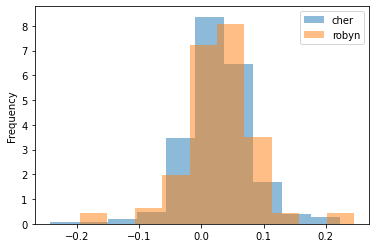

In [17]:
len_df = lyric_df[['Artist','Sentiment Score']].copy()
len_df.groupby('Artist')['Sentiment Score'].plot(kind="hist",
                                                 density=True,
                                                 alpha=0.5,
                                                 legend=True)

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [18]:
# your code here
emoji_dict = {}
positive_emojis = ["😀","😂","😁","🤣","🙏","😊","😍","🥰","😘","😜","😉"]
negative_emojis = ["😒","🤨","😒","😞","😟","😫","🤬","😡","😤","😭","💔"]

In [19]:
for emoji in positive_emojis:
    emoji_dict[emoji] = pos_score
    
for emoji in negative_emojis:
    emoji_dict[emoji] = neg_score

In [20]:
robyn_followers_data_df['Emoji Sentiment Score'] = robyn_followers_data_df['description'] \
.apply(emoji_sentiment_score)
robyn_followers_data_df['Word Sentiment Score'] = robyn_followers_data_df['description'] \
.apply(my_sentiment_score)
robyn_followers_data_df['Total Sentiment'] = robyn_followers_data_df['Emoji Sentiment Score'] \
+ robyn_followers_data_df['Word Sentiment Score']
robyn_followers_data_df.sort_values(by='Total Sentiment', ascending=False)

,screen_name,name,id,location,followers_count,friends_count,description,Emoji Sentiment Score,Word Sentiment Score,Total Sentiment
194970,rthompson1138,Robbie Thompson,1078680727,NaN,55207,779,writer,0.0,1.0,1.0
181398,_rhiesty,rhiesty ptri pertiwi,1326815173,THERE IS NO PERFECT MAN'',15,452,happy,0.0,1.0,1.0
10835,Qorane62426949,🥰🥰💋,1294562990621102081,NaN,10,258,welcome,0.0,1.0,1.0
10850,Thanh68592115,thanh_nguyen,1294320306832592896,"Ho Chi Minh, Vietnam",6,123,sweet,0.0,1.0,1.0
31957,metronomevn,Metronome Vietnam,1082483805191958528,"Ho Chi Minh, Vietnam",0,40,😊,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
153175,ItsNietzsche,human canvas,2225472937,a human brain,4,82,turbulence,0.0,-1.0,-1.0
350422,MANIAC1,Frank Wagner,23157755,Berlin,7,17,disturbed,0.0,-1.0,-1.0
2917,rhelkowski,Shady Rach,1077728893,NaN,95,335,Chaos Goblin,0.0,-1.0,-1.0
227042,ohaiChris,Andrew Christopher,177431713,"Fort Worth/Austin, TX",139,159,irrelevant,0.0,-1.0,-1.0


In [21]:
print(robyn_followers_data_df['Total Sentiment'].sum()/len(robyn_followers_data_df))

0.025058378162783963


In [22]:
cher_followers_data_df['Emoji Sentiment Score'] = cher_followers_data_df['description'] \
.apply(emoji_sentiment_score)
cher_followers_data_df['Word Sentiment Score'] = cher_followers_data_df['description'] \
.apply(my_sentiment_score)
cher_followers_data_df['Total Sentiment'] = cher_followers_data_df['Emoji Sentiment Score'] \
+ cher_followers_data_df['Word Sentiment Score']
cher_followers_data_df.sort_values(by='Total Sentiment', ascending=False)


,screen_name,name,id,location,followers_count,friends_count,description,Emoji Sentiment Score,Word Sentiment Score,Total Sentiment
859253,Jack_Zade,Jack Zade,9.678204e+17,London,9.0,179.0,Music Producer,0.0,1.0,1.0
692447,JamilLee17,Jamil Lee,1.147372e+18,NaN,3.0,188.0,sexy,0.0,1.0,1.0
355094,nickmccart,Nick McCart,1.536071e+07,"Austin, TX",907.0,1360.0,Ready,0.0,1.0,1.0
1367503,An_Ning_,安小宁,8.516829e+17,People's Republic of China,0.0,79.0,optimistic powerful,0.0,1.0,1.0
1255753,WriteArchives,NCAnderson,5.257547e+08,Southern California,16.0,223.0,Writer,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
707494,Em_0205,Emily Molyneux-Downs,3.742441e+09,NaN,72.0,396.0,bored,0.0,-1.0,-1.0
1270246,luka08072002,lucosmico,3.029199e+09,"Curitiba, Brasil",56.0,439.0,Bitch,0.0,-1.0,-1.0
2427756,madamescher,marcela Schernitzki,2.434914e+09,"Buenos Aires, Argentina",63.0,523.0,Mar,0.0,-1.0,-1.0
609799,AndrewM25523759,AndrewMann,1.188006e+18,NaN,0.0,3.0,Funny,0.0,-1.0,-1.0


In [23]:
print(cher_followers_data_df['Total Sentiment'].sum()/len(cher_followers_data_df))

0.02944641231483891


In [27]:
emoji_tokens = []
for post in robyn_followers_data_df['description']:
    bag_of_words = word_tokenize(post.lower())
    for word in bag_of_words:
        if word in emoji_dict:
            emoji_tokens.append(word)
counter = Counter(emoji_tokens)
print(counter)

Counter({'😊': 77, '😉': 72, '😍': 57, '🥰': 56, '😘': 51, '😂': 46, '🙏': 41, '😁': 39, '😜': 37, '😀': 27, '🤣': 23, '💔': 15, '😒': 9, '😭': 9, '🤨': 4, '🤬': 4, '😡': 3, '😤': 2, '😟': 1, '😫': 1})


In [28]:
emoji_tokens = []
for post in cher_followers_data_df['description']:
    bag_of_words = word_tokenize(post.lower())
    for word in bag_of_words:
        if word in emoji_dict:
            emoji_tokens.append(word)
counter = Counter(emoji_tokens)
print(counter)

Counter({'😊': 1867, '😍': 1644, '😉': 1461, '🥰': 1326, '😘': 1233, '😁': 1002, '😂': 997, '🙏': 975, '😜': 753, '😀': 633, '💔': 398, '🤣': 375, '😭': 135, '😡': 112, '🤬': 104, '😒': 100, '🤨': 93, '😤': 75, '😞': 35, '😫': 19, '😟': 12})


Q: What is the average sentiment of your two artists? 

A: For Robyn, the average sentiment is 0.025058378162783963 while Cher has an average of 0.02944641231483891. 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: For Robyn and Cher, they both have the same most popular positive and negative emojis which are the smiley face with the rosy cheeks and the broken heart emoji, respectively.

